### **Import libraries**

In [108]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from pandas.plotting import scatter_matrix
import pandas as pd
from sklearn.cluster import KMeans



In [109]:
# Import your functions from fetch_data.py
from fetch_data import fetch_housing_data, load_housing_data
# Download and extract data if not done already
fetch_housing_data()
# Load the housing data into a pandas DataFrame
housing = load_housing_data()

Data already downloaded and extracted.


### 🔍 **Take a Quick Look at the Data Structure**

Let’s begin by examining the top five rows using the DataFrame’s `head()` method.  
Each row in the dataset represents a district in California.


#### 📌 **There are 10 attributes in the dataset:**

- `longitude`  
- `latitude`  
- `housing_median_age`  
- `total_rooms`  
- `total_bedrooms`  
- `population`  
- `households`  
- `median_income`  
- `median_house_value`  
- `ocean_proximity`  


The `info()` method provides a quick summary of the dataset, including:
- The total number of entries (rows)
- Data types of each column
- The number of non-nul


In [110]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [111]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [112]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


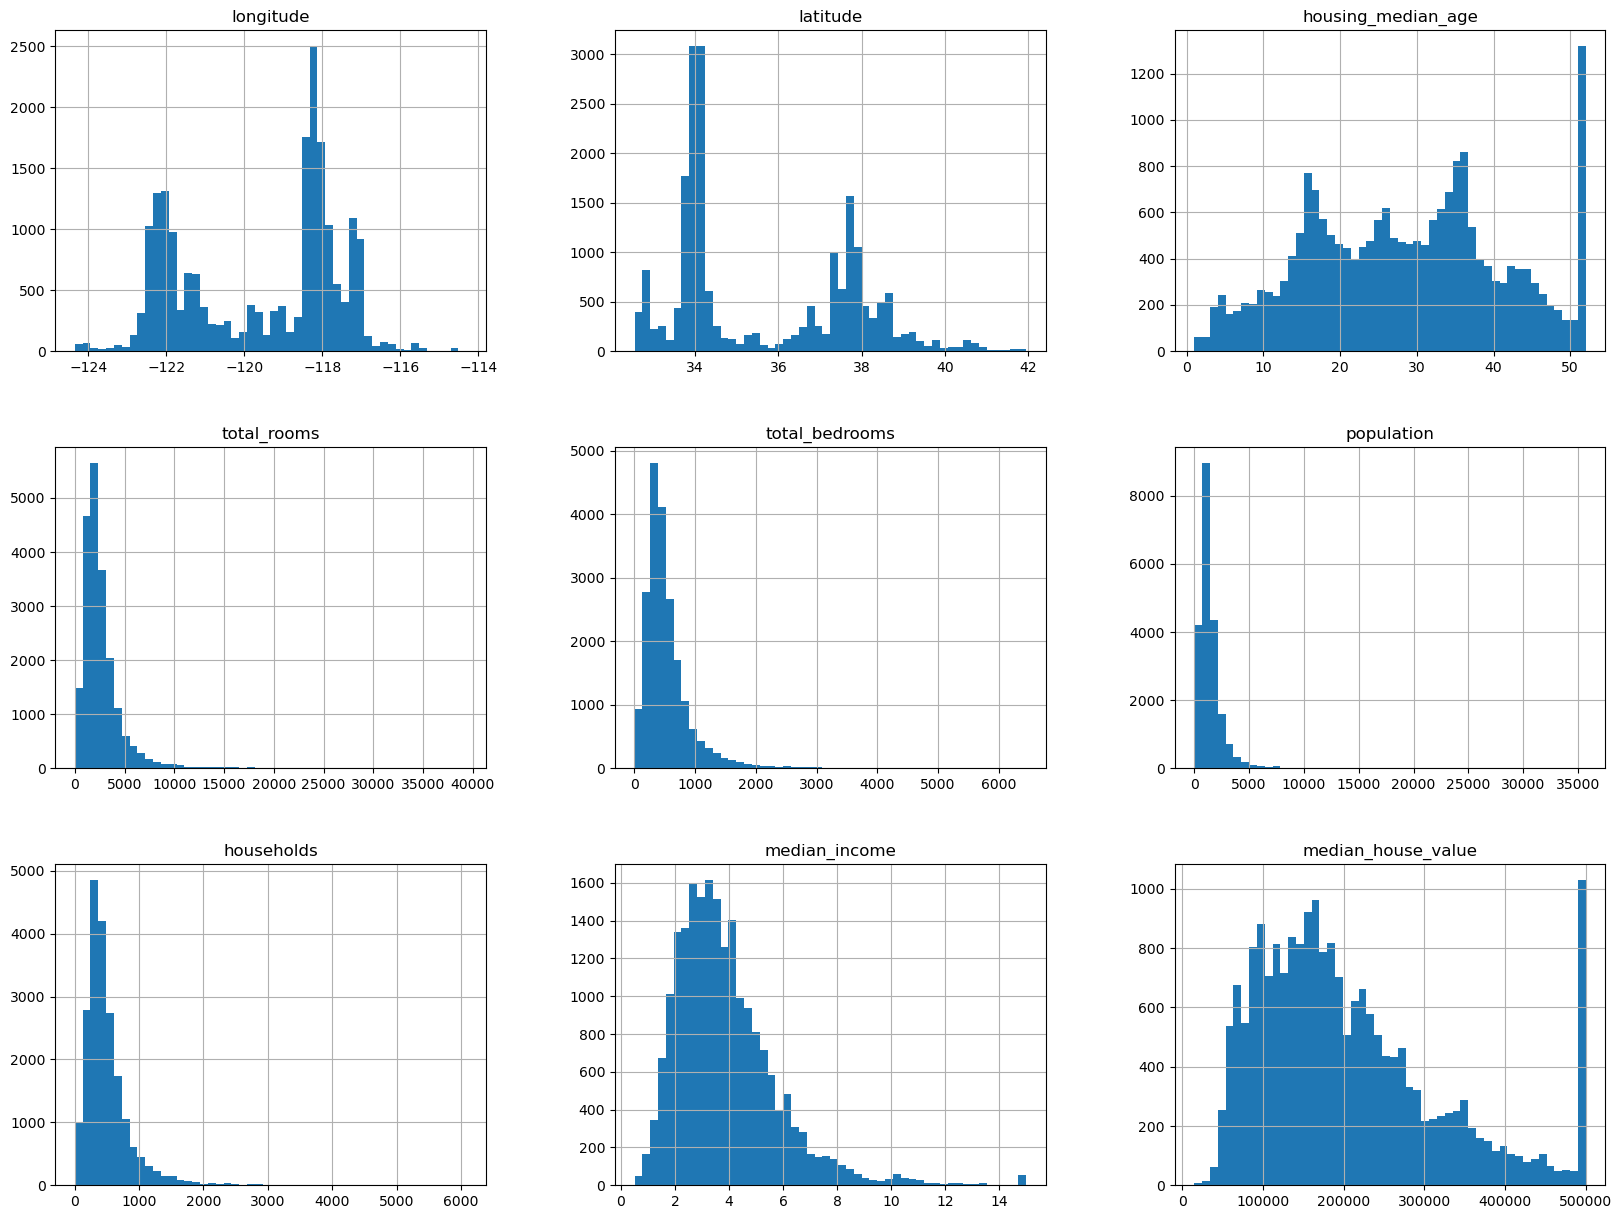

In [113]:
%matplotlib inline
# only in a Jupyter notebook

housing.hist(bins=50, figsize=(20,15))
plt.show()

### Notice a few things in these histograms:

1. **Median Income Scale**  
   The `median_income` attribute does not appear to be expressed in US dollars (USD).  
   After checking with the data collection team, you learn that:
   - The data has been **scaled** and **capped** at **15.0001** for high incomes and at **0.4999** for low incomes.
   - The values represent **tens of thousands of dollars** (e.g., `3` ≈ `$30,000`).

   > 📌 Working with preprocessed attributes is common in Machine Learning.  
   > It's not always an issue, but understanding how the data was processed is important.

2. **Capped Values: Housing Median Age and Median House Value**  
   - These features were also **capped**.
   - Capping the **median house value** may be a serious issue since it is the **target attribute** (label).
   - If the ML algorithm sees only values below a certain threshold (e.g., \$500,000), it may **learn incorrectly** that values never exceed this.

   #### What to do if precise predictions > \$500,000 are needed?
   - **Option 1**: Collect **uncapped labels** for those districts.
   - **Option 2**: Remove those districts from the **training and test sets** so the model is not unfairly penalized.

3. **Different Feature Scales**  
   - The features have very **different scales** (e.g., income vs. housing age).
   - This will require **feature scaling**, which we'll explore later in this chapter.

4. **Tail-Heavy Distributions**  
   - Many histograms are **right-skewed** (tail heavy).
   - This makes it harder for some ML algorithms to **detect patterns**.


### 🧪 **Create a Test Set**

It may seem strange to set aside part of the data before diving deeper into analysis.  
After all, shouldn’t we learn more about the data first?

However:

> ⚠️ **Your brain is an amazing pattern detection system, and that makes it prone to overfitting.**

If you examine the test set early, you may notice patterns and **subconsciously overfit** your model.  
This leads to **data snooping bias**: your system performs well in testing, but poorly in the real world.

#### ✅ **Best Practice:**

Create a test set **right away**:

- Pick a random subset of the data — typically **20%** (or less if the dataset is large)
- Set it aside and **never look at it** until the final evaluation stage



In [114]:
def split_train_data(data , test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices] , data.iloc[test_indices]

In [115]:
train_set , test_set = split_train_data(housing , 0.2)
print(len(train_set))
print(len(test_set))

16512
4128


In [116]:
train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
4307,-118.48,34.00,29.0,1727.0,479.0,741.0,431.0,3.6121,500000.0,<1H OCEAN
18958,-122.43,37.72,50.0,2912.0,562.0,1989.0,537.0,3.6667,252600.0,NEAR BAY
11539,-118.29,34.17,17.0,3852.0,1066.0,2986.0,993.0,2.3482,255400.0,<1H OCEAN
12470,-118.03,34.05,36.0,1359.0,317.0,1557.0,370.0,2.7955,157500.0,<1H OCEAN
19410,-118.31,34.06,14.0,1559.0,646.0,1639.0,567.0,1.9949,380000.0,<1H OCEAN


In [117]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
6273,-122.20,37.77,39.0,2689.0,597.0,1888.0,537.0,2.2562,94800.0,NEAR BAY
5511,-122.87,38.62,18.0,2721.0,557.0,1667.0,539.0,3.1875,176100.0,<1H OCEAN
2260,-118.26,34.08,52.0,984.0,276.0,994.0,260.0,2.3816,166700.0,<1H OCEAN
15123,-119.15,36.29,18.0,1435.0,NaN,657.0,254.0,2.4281,72500.0,INLAND
6306,-122.44,37.80,52.0,1603.0,487.0,727.0,464.0,3.9856,500001.0,NEAR BAY


In [118]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

### 🎯 **Reliable & Representative Test Set Creation , Stratified Sampling**

Splitting the dataset randomly can cause the test set to have skewed proportions of key categories. Stratified sampling divides the data into subgroups (strata) and samples proportionally from each, preserving the overall distribution in the test set.

#### 🎯 **Why Stratified Sampling?**

Purely random sampling usually works well with large datasets. However, if the dataset is small or some features are unevenly distributed, random sampling may produce **biased samples**.

For example, in a survey of 1,000 people, the US population is roughly 51.3% female and 48.7% male. A well-designed survey maintains this ratio to get **representative results**. Pure random sampling could result in skewed gender ratios in the sample, biasing the outcomes.

This approach of dividing the population into **homogeneous subgroups (strata)** and sampling proportionally from each is called **stratified sampling**. It ensures the test set reflects the overall population accurately.


#### 🏷️ **Creating Income Categories for Stratification**

If a numerical feature like **median income** is crucial for prediction, you can turn it into a categorical attribute to stratify by income level.

Using `pd.cut()`, the continuous median income is split into 5 categories representing income ranges:

- Category 1: 0 to 1.5 (less than $15,000)  
- Category 2: 1.5 to 3  
- Category 3: 3 to 4.5  
- Category 4: 4.5 to 6  
- Category 5: 6 and above

This helps ensure the train and test sets maintain similar distributions of income levels.



#### 🧪 **Train-Test Split with Stratified Sampling**

To ensure the test set represents the overall population well—especially for imbalanced categories—we used **Stratified Sampling** via `Scikit-Learn`.

- The `ocean_proximity` feature is categorical and location-based, making it a good candidate for stratified sampling.
- To stratify on income, we created an `income_cat` attribute using the `median_income` feature.


In [119]:
housing['income_cat'] = pd.cut(housing['median_income'] , bins=[0.,1.5,3.0,4.5,6. , np.inf] , labels=[1,2,3,4,5])

In [120]:
housing['income_cat'].hist()

<Axes: >

In [121]:
split = StratifiedShuffleSplit(n_splits=1 , test_size=0.2 , random_state=42)
for train_index , test_index in split.split(housing , housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

- Let’s see if this worked as expected. You can start by looking at the income category
proportions in the test set:

In [122]:
strat_test_set.income_cat.value_counts()/len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

* We then performed a **Stratified Shuffle Split** to maintain the `income_cat` distribution in both training and test sets.

After the split, we removed the `income_cat` column to restore the datasets to their original state:


In [123]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [124]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3


### 🔍 Next Step: Data Exploration

With a properly split dataset, we now begin **exploring the data** to gain insights and prepare it for the machine learning pipeline.


In [125]:
housing = strat_train_set.copy()

### 📍 **Visualizing Geographical Data**

We have **geographical information**—specifically `latitude` and `longitude`. Plotting these as a scatterplot helps visualize **district locations** on the map.

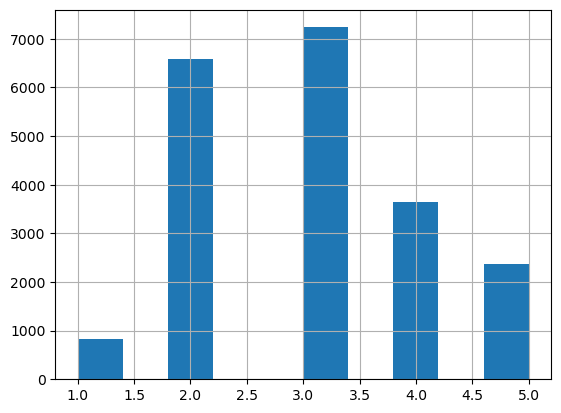

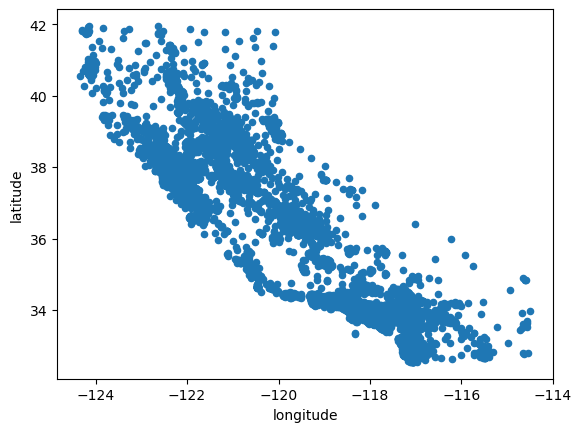

In [126]:
housing.plot(kind="scatter", x="longitude", y="latitude")
plt.show()

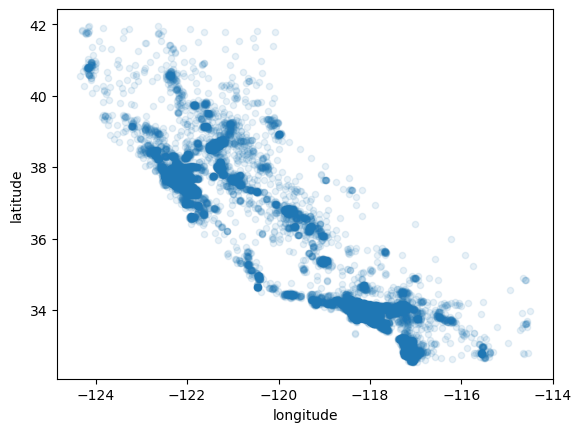

In [127]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
plt.show()

### 🌍 **Visualizing Geographical Data with Housing Prices**

Now that we have a basic scatter plot of the districts using longitude and latitude, we can improve the visualization by adding more dimensions to the plot:

- **Circle radius** will represent the population of each district.
- **Color** will represent the median house value.
- We'll use the `jet` colormap (`cmap='jet'`) which ranges from blue (low) to red (high prices).

This enhanced scatter plot helps us spot geographic patterns in housing prices and population distribution more effectively.

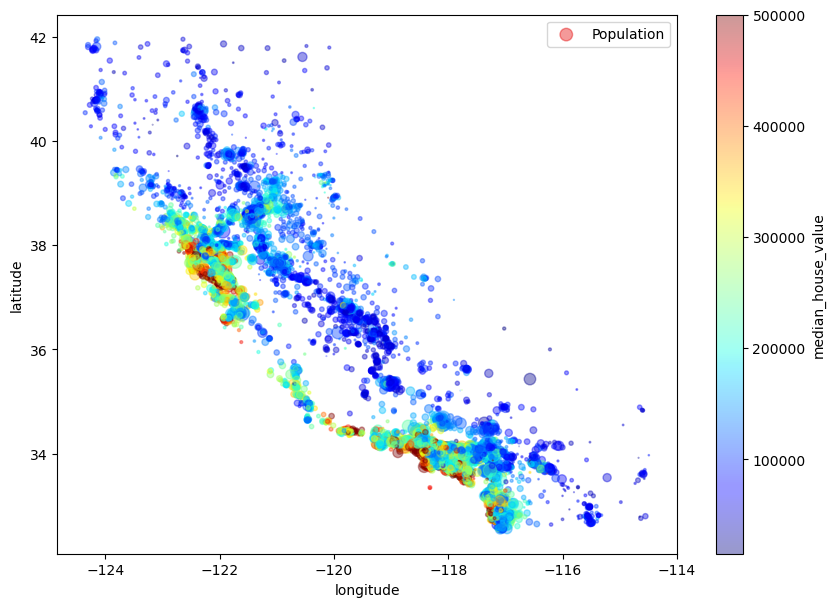

In [128]:
housing.plot(
    kind="scatter", 
    x="longitude", 
    y="latitude", 
    alpha=0.4,
    s=housing["population"] / 100,  # radius of circle
    label="Population",
    c="median_house_value",         # color represents house value
    cmap=plt.get_cmap("jet"),       # color map
    colorbar=True,
    figsize=(10,7)
)
plt.show()

### 🗺️ **Geographical Data Insights**

This image tells you that the housing prices are very much related to the **location** (e.g., close to the ocean) and to the **population density**, as you probably knew already.

It will probably be useful to:

- 🧠 Use a **clustering algorithm** to detect the main clusters.
- ➕ Add new features that measure the **proximity to the cluster centers**.
- 🌊 Consider the **ocean proximity** attribute, although in Northern California the housing prices in coastal districts are not always high — so it's not a simple rule.

These insights can guide better **feature engineering** and help improve your model's performance.


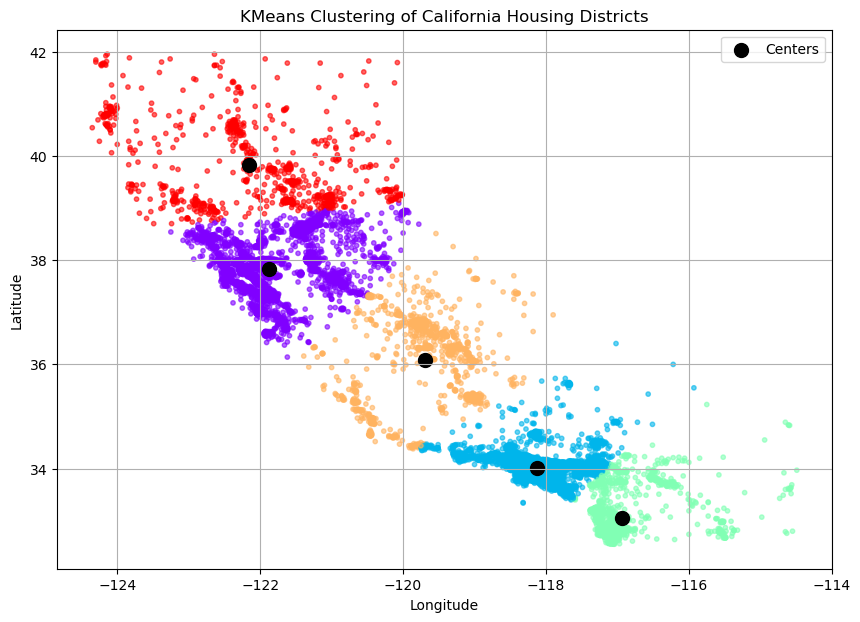

In [129]:
# Extract latitude and longitude
housing_geo = housing[["latitude", "longitude"]]

# Apply KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
housing["cluster"] = kmeans.fit_predict(housing_geo)

# Add distance to cluster center as a new feature
housing["dist_to_center"] = np.linalg.norm(housing_geo - kmeans.cluster_centers_[housing["cluster"]], axis=1)

# Plot to visualize the clusters
plt.figure(figsize=(10, 7))
plt.scatter(housing["longitude"], housing["latitude"], c=housing["cluster"], cmap='rainbow', alpha=0.6, s=10)
plt.scatter(kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 0], c='black', s=100, label="Centers")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("KMeans Clustering of California Housing Districts")
plt.legend()
plt.grid(True)
plt.show()


### 🔍 **Looking for Correlations**

Since the dataset is not too large, we can compute the standard correlation coefficient (also called **Pearson’s r**) between every pair of attributes using the `corr()` method.

This allows us to see how strongly each feature is linearly related to the target variable `median_house_value`.

We will use the `.corr()` method on the DataFrame to get a correlation matrix and then inspect how each feature correlates with the target.


In [130]:
# Compute the correlation matrix
corr_matrix = housing.corr(numeric_only=True)

# Display correlation of each feature with median_house_value
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
dist_to_center       -0.233670
cluster              -0.328379
Name: median_house_value, dtype: float64

### **Understanding Correlation Coefficients**

The correlation coefficient ranges from **-1 to 1**:

- When it is close to **1**, it indicates a **strong positive correlation**. For example, the median house value tends to increase as median income increases.
- When it is close to **-1**, it indicates a **strong negative correlation**. For instance, there is a slight negative correlation between latitude and median house value, meaning prices tend to decrease as you move north.
- When it is close to **0**, it means **no linear correlation** exists between the variables.

### **Checking Correlations with Scatter Matrix**

Another useful way to explore correlations between attributes is to use Pandas' `scatter_matrix` function. This plots every numerical attribute against every other numerical attribute, making it easy to spot relationships.

Since our dataset has 11 numerical attributes (which would result in 121 plots), we will focus only on a few key attributes that appear most correlated with `median_house_value` for clarity.

These attributes are:  
- `median_house_value`  
- `median_income`  
- `total_rooms`  
- `housing_median_age`  

Below is the scatter matrix for these attributes.


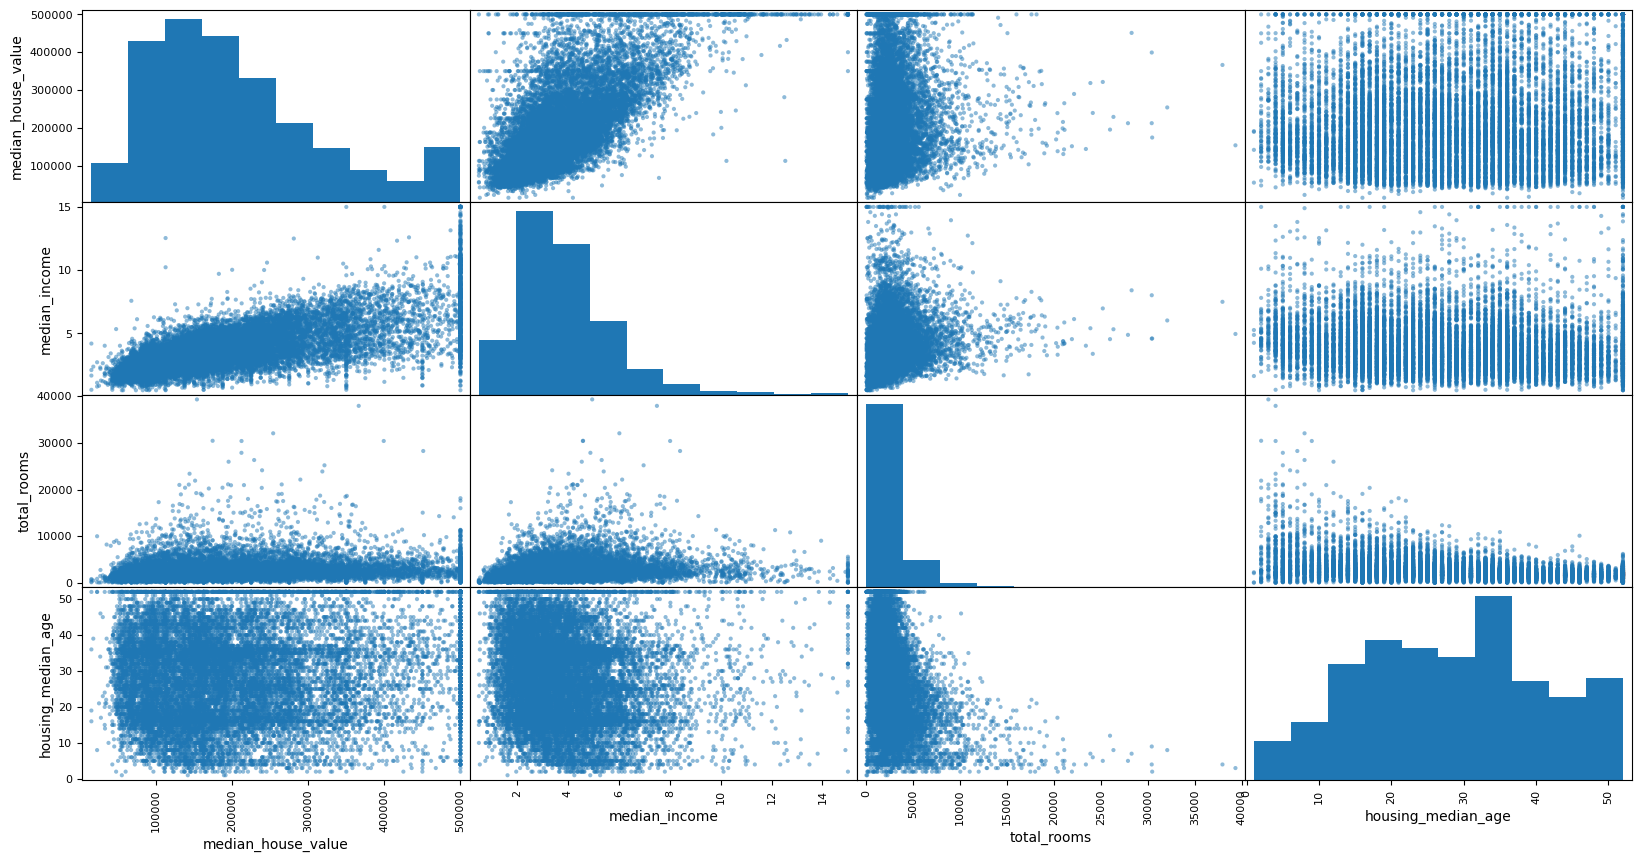

In [131]:
attributes = ["median_house_value", "median_income", "total_rooms",
"housing_median_age"]
scatter_matrix(housing[attributes] , figsize=(20,10))
plt.show()

### **Scatterplot: Median Income vs. Median House Value**

The main diagonal in the scatter matrix shows histograms of each attribute, which helps us understand their distributions.

Focusing on the most promising predictor — **median income** — we plot it against the **median house value**.

This scatterplot shows:

- A strong positive correlation: as median income increases, so does the median house value.
- Visible horizontal lines indicating price caps, notably at \$500,000 and other price thresholds around \$450,000, \$350,000, and \$280,000.
- These capped values represent quirks in the data that might mislead the model, so you may consider removing those districts during preprocessing.

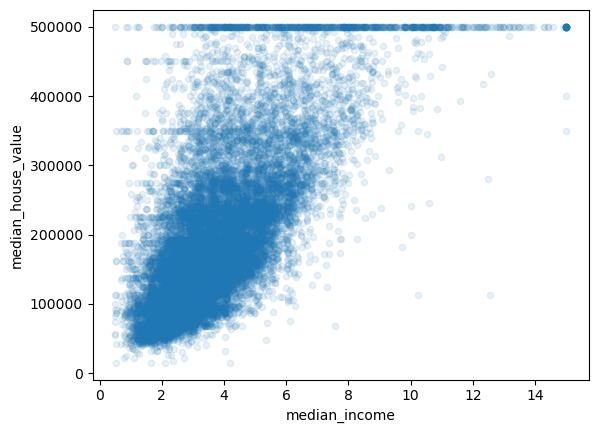

In [132]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)
plt.show()

### **Experimenting with Attribute Combinations**

Hopefully, the previous sections gave you an idea of a few ways you can explore the data and gain insights. You identified a few data quirks that you may want to clean up before feeding the data to a Machine Learning algorithm, and you found interesting correlations between attributes, in particular with the target attribute.

You also noticed that some attributes have a tail-heavy distribution, so you may want to transform them (e.g., by computing their logarithm). Of course, your mileage will vary considerably with each project, but the general ideas are similar.

One last thing you may want to do before actually preparing the data for Machine Learning algorithms is to try out various attribute combinations. For example, the total number of rooms in a district is not very useful if you don’t know how many households there are. What you really want is the number of rooms per household.

Similarly, the total number of bedrooms by itself is not very useful: you probably want to compare it to the number of rooms. And the population per household also seems like a useful attribute to consider.


In [133]:
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['rooms_per_household'] = housing['rooms_per_household'].round().astype(int)
housing['total_rooms'] = housing['total_rooms'].round().astype(int)
#housing['total_bedrooms'] = housing['total_bedrooms'].round().astype(int)
housing['population'] = housing['population'].round().astype(int)
housing['households'] = housing['households'].round().astype(int)

In [134]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,cluster,dist_to_center,rooms_per_household
13096,-122.42,37.80,52.0,3321,1115.0,1576,1034,2.0987,458300.0,NEAR BAY,0,0.539980,3
14973,-118.38,34.14,40.0,1965,354.0,666,357,6.0876,483800.0,<1H OCEAN,1,0.276006,6
3785,-121.98,38.36,33.0,1083,217.0,562,203,2.4330,101700.0,INLAND,0,0.540661,5
14689,-117.11,33.75,17.0,4174,851.0,1845,780,2.2618,96100.0,INLAND,2,0.727175,5
20507,-118.15,33.77,36.0,4366,1211.0,1912,1172,3.5292,361800.0,NEAR OCEAN,1,0.249486,4


In [135]:
corr_matrix = housing.select_dtypes(include=[float, int]).corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value     1.000000
median_income          0.688380
rooms_per_household    0.144562
total_rooms            0.137455
housing_median_age     0.102175
households             0.071426
total_bedrooms         0.054635
population            -0.020153
longitude             -0.050859
latitude              -0.139584
dist_to_center        -0.233670
cluster               -0.328379
Name: median_house_value, dtype: float64

In [136]:
housing_encoded = pd.get_dummies(housing)
corr_matrix = housing_encoded.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value            1.000000
median_income                 0.688380
ocean_proximity_<1H OCEAN     0.257132
ocean_proximity_NEAR BAY      0.166398
rooms_per_household           0.144562
ocean_proximity_NEAR OCEAN    0.138747
total_rooms                   0.137455
housing_median_age            0.102175
households                    0.071426
total_bedrooms                0.054635
ocean_proximity_ISLAND        0.023258
population                   -0.020153
longitude                    -0.050859
latitude                     -0.139584
dist_to_center               -0.233670
cluster                      -0.328379
ocean_proximity_INLAND       -0.485070
Name: median_house_value, dtype: float64

### **Preparing the Data for Machine Learning Algorithms**

This round of exploration does not have to be absolutely thorough; the point is to start off on the right foot and quickly gain insights that will help you get a first reasonably good prototype. 

This is an **iterative process**: once you get a prototype up and running, you can analyze its output to gain more insights and come back to this exploration step.

---

#### **Why Write Data Preparation Functions?**

Instead of preparing the data manually, it’s better to write **functions** for your transformations. This has several benefits:

- **Reproducibility**: Easily apply the same transformations to any dataset (e.g., when you get fresh data).
- **Reusability**: Build a library of transformation functions for future projects.
- **Integration**: Use the same functions in your live system to transform new data before prediction.
- **Experimentation**: Quickly try different transformation combinations to find the best setup.

---

#### **Next Step**

1. Revert to a clean training set (by copying `strat_train_set` again).
2. Separate **predictors** and **labels**, since transformations applied to features might not be the same as those applied to the target variable.

> **Note:** `drop()` creates a copy of the DataFrame and does **not** modify `strat_train_set` in place.


In [137]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [138]:
housing_labels

13096    458300.0
14973    483800.0
3785     101700.0
14689     96100.0
20507    361800.0
           ...   
14207    500001.0
13105     88800.0
19301    148800.0
19121    500001.0
19888    233300.0
Name: median_house_value, Length: 16512, dtype: float64

### **Data Cleaning**

Most Machine Learning algorithms cannot work with missing features, so we need to handle them before training.

Earlier, we noticed that the **`total_bedrooms`** attribute has some missing values. There are three common strategies to fix this:

1. **Remove the corresponding rows** (districts) that have missing values.  
2. **Remove the entire column** that contains missing values.  
3. **Fill the missing values** with a specific value (e.g., 0, the mean, the median, etc.).



#### **Pandas Methods for Handling Missing Data**

- **`dropna()`** → Remove rows with missing values.  
- **`drop()`** → Remove specific columns.  
- **`fillna()`** → Replace missing values with a given constant or a computed value.



> The right choice depends on the dataset and problem — removing too much data can harm your model, while filling with the wrong value can introduce bias.


### **Handling Missing Values with Scikit-Learn**

If you choose **Option 3** (filling missing values with the median), remember:

- **Compute the median** only on the **training set**.
- **Save** the computed median so you can:
  - Fill missing values in the test set when evaluating.
  - Fill missing values in new incoming data once the system is live.

---

#### **Using `SimpleImputer` in Scikit-Learn**

Instead of manually computing and applying the median, Scikit-Learn provides the **`SimpleImputer`** class, which can automatically handle missing values.

In [139]:
imputer = SimpleImputer(strategy='median')
#Since the median can only be computed on numerical attributes, we need to create a copy of the data without the text attribute ocean_proximity:
housing_num = housing.drop('ocean_proximity' , axis=1)

In [140]:
#Now you can fit the imputer instance to the training data using the fit() method:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

The `SimpleImputer` stores each attribute’s median in `statistics_`.  
Right now, only **`total_bedrooms`** has missing values, but future data may have gaps in other numeric fields.  
To be safe, apply the imputer to **all numeric attributes**.


In [141]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [142]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

Now we can use the **trained** imputer to replace missing values with the learned medians:

In [143]:
X = imputer.transform(housing_num)

The result is a NumPy array of transformed features.  
To convert it back to a DataFrame:

In [144]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

In [145]:
housing_tr

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987
1,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876
2,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330
3,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618
4,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292
...,...,...,...,...,...,...,...,...
16507,-118.40,33.86,41.0,2237.0,597.0,938.0,523.0,4.7105
16508,-119.31,36.32,23.0,2945.0,592.0,1419.0,532.0,2.5733
16509,-117.06,32.59,13.0,3920.0,775.0,2814.0,760.0,4.0616
16510,-118.40,34.06,37.0,3781.0,873.0,1725.0,838.0,4.1455


### **Handling Text & Categorical Values.**
Most Machine Learning algorithms prefer to work with numbers anyway, so let’s con‐
vert these categories from text to numbers. For this, we can use Scikit-Learn’s Ordina
lEncoder class19:

In [146]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head()

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN


In [147]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.],
       [0.],
       [0.]])

### **Custom Transformers**

In [148]:
housing_tr

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987
1,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876
2,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330
3,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618
4,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292
...,...,...,...,...,...,...,...,...
16507,-118.40,33.86,41.0,2237.0,597.0,938.0,523.0,4.7105
16508,-119.31,36.32,23.0,2945.0,592.0,1419.0,532.0,2.5733
16509,-117.06,32.59,13.0,3920.0,775.0,2814.0,760.0,4.0616
16510,-118.40,34.06,37.0,3781.0,873.0,1725.0,838.0,4.1455


In [149]:
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
            bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In this example the transformer has one hyperparameter, add_bedrooms_per_room,
set to True by default (it is often helpful to provide sensible defaults). This hyperpara‐
meter will allow you to easily find out whether adding this attribute helps the
Machine Learning algorithms or not.

### **Feature Scaling**
One of the most important transformations you need to apply to your data is feature
scaling. With few exceptions, Machine Learning algorithms don’t perform well when
the input numerical attributes have very different scales.

### **Transformation Pipelines**
As you can see, there are many data transformation steps that need to be executed in
the right order. Fortunately, Scikit-Learn provides the Pipeline class to help with
such sequences of transformations. Here is a small pipeline for the numerical
attributes:

In [150]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

So far, we have handled the categorical columns and the numerical columns sepa‐
rately. It would be more convenient to have a single transformer able to handle all col‐
umns, applying the appropriate transformations to each column. In version 0.20,
Scikit-Learn introduced the ColumnTransformer for this purpose, and the good news
is that it works great with Pandas DataFrames. Let’s use it to apply all the transforma‐
tions to the housing data:

In [151]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

num_attrbs = list(housing_num)
cat_attrbs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
    ('nums' , num_pipeline , num_attrbs),
    ('cat' , OneHotEncoder() , cat_attrbs)
])

housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.42303652,  1.0136059 ,  1.86111875, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.59639445, -0.702103  ,  0.90762971, ...,  0.        ,
         0.        ,  0.        ],
       [-1.2030985 ,  1.27611874,  0.35142777, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.25620853, -1.42870103, -1.23772062, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.58639727, -0.73960483,  0.66925745, ...,  0.        ,
         0.        ,  0.        ],
       [-1.41803793,  0.94797769,  1.22545939, ...,  0.        ,
         0.        ,  1.        ]])

### **Select and Train a Model**
At last! You framed the problem, you got the data and explored it, you sampled a
training set and a test set, and you wrote transformation pipelines to clean up and
prepare your data for Machine Learning algorithms automatically. You are now ready
to select and train a Machine Learning model.

### **Training and Evaluating on the Training Set**

In [152]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared , housing_labels)

LinearRegression()

In [153]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print('Predictions: ' , lin_reg.predict(some_data_prepared))
print('Labels:' , some_labels)

Predictions:  [276608.27419651 333603.0303772  118237.5726011  108255.75159886
 308943.82732346]
Labels: 13096    458300.0
14973    483800.0
3785     101700.0
14689     96100.0
20507    361800.0
Name: median_house_value, dtype: float64


It works, although the predictions are not exactly accurate (e.g., the first prediction is
off by close to 40%!). Let’s measure this regression model’s RMSE on the whole train‐
ing set using Scikit-Learn’s mean_squared_error function:

In [154]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print(f'Error: {lin_rmse}')

Error: 67769.12117461127


- Okay, this is better than nothing but clearly not a great score: most districts’
median_housing_values range between $120,000 and $265,000, so a typical predic‐
tion error of $68,628 is not very satisfying. This is an example of a model underfitting
the training data. When this happens it can mean that the features do not provide
enough information to make good predictions, or that the model is not powerful
enough. As we saw in the previous chapter, the main ways to fix underfitting are to
select a more powerful model, to feed the training algorithm with better features, or
to reduce the constraints on the model. This model is not regularized, so this rules
out the last option. You could try to add more features (e.g., the log of the popula‐
tion), but first let’s try a more complex model to see how it does.
Let’s train a DecisionTreeRegressor. 

- This is a powerful model, capable of finding
complex nonlinear relationships in the data (Decision Trees are presented in more
detail in Chapter 6). The code should look familiar by now:

In [155]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

#Now that the model is trained, let’s evaluate it on the training set:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print(f"Error: {tree_rmse}")

Error: 0.0


Could this model really be absolutely perfect? Of course,
it is much more likely that the model has badly overfit the data. How can you be sure?
As we saw earlier, you don’t want to touch the test set until you are ready to launch a
model you are confident about, so you need to use part of the training set for train‐
ing, and part for model validation.

### **Better Evaluation Using Cross-Validation**

In [156]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print(f'Scores : {scores}')
    print(f'Mean : {scores.mean()}')
    print(f'Standard deviation : {scores.std()}')

display_scores(tree_rmse_scores)

Scores : [67851.35277512 67031.53686455 68065.26379318 72059.72062087
 70124.78417498 68597.79816042 73507.75101748 72702.2538384
 68756.84797767 69215.29119521]
Mean : 69791.2600417888
Standard deviation : 2114.8951927682706


Now the Decision Tree doesn’t look as good as it did earlier. In fact, it seems to per‐
form worse than the Linear Regression model! Notice that cross-validation allows
you to get not only an estimate of the performance of your model, but also a measure
of how precise this estimate is (i.e., its standard deviation). The Decision Tree has a
score of approximately 71,407, generally ±2,439. You would not have this information
if you just used one validation set. But cross-validation comes at the cost of training
the model several times, so it is not always possible.
#### **Let’s compute the same scores for the Linear Regression model just to be sure:**

In [157]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

def display_scores(scores):
    print(f'Scores : {scores}')
    print(f'Mean : {scores.mean()}')
    print(f'Standard deviation : {scores.std()}')

display_scores(lin_rmse_scores)

Scores : [69717.57852026 66650.26617871 66488.43193213 70478.22519838
 66837.93229332 68220.31091521 66922.70445332 69700.47781664
 67122.26131607 67802.47918508]
Mean : 67994.06678091262
Standard deviation : 1394.937701550329


**That’s right: the Decision Tree model is overfitting so badly that it performs worse
than the Linear Regression model.**

Let’s try one last model now: the RandomForestRegressor. As we will see in Chap‐
ter 7, Random Forests work by training many Decision Trees on random subsets of
the features, then averaging out their predictions. Building a model on top of many
other models is called Ensemble Learning, and it is often a great way to push ML algo‐
rithms even further. We will skip most of the code since it is essentially the same as
for the other models:

In [158]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
[...]
forest_rmse

display_scores(forest_rmse_scores)

NameError: name 'forest_rmse' is not defined

Random Forests look very promising. However, note that
the score on the training set is still much lower than on the validation sets, meaning
that the model is still overfitting the training set. Possible solutions for overfitting are
to simplify the model, constrain it (i.e., regularize it), or get a lot more training data.
However, before you dive much deeper in Random Forests, you should try out many
other models from various categories of Machine Learning algorithms (several Sup‐
port Vector Machines with different kernels, possibly a neural network, etc.), without
spending too much time tweaking the hyperparameters. The goal is to shortlist a few
(two to five) promising models

### **Fine-Tune Your Model.**
Let’s assume that you now have a shortlist of promising models. You now need to
fine-tune them. Let’s look at a few ways you can do that.

In [159]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(
        forest_reg, param_grid, cv=5,
        scoring='neg_mean_squared_error',
        return_train_score=True
)

grid_search.fit(housing_prepared, housing_labels)
grid_search.best_params_
grid_search.best_estimator_

AttributeError: 'GridSearchCV' object has no attribute 'best_estimators'